#  Scalable K-Means++

# Background

K-means has been one the the most popular clustering algorithm. The method is used to divide the data set into k clusters. Starting from a set of randomly chosen initial points, the algorithm assign them to nearest centers and then updating new centers according to these new points. Thus, this is a iterative process. K-means method is popular and scalable due to its simple iterative nature. However, the running time is exponential in worst case and the final result may be local optimum, not global optimum.

To solve these problems, recent researches try to improving initial assignment. K-means++ is such an improved algorithm that finds proper initialization points. Downside of this algorithm is that it is still sequential process which total running time of $O(nkd)$, which limits its efficiency in massive datasets cases.

The paper Scalable k-means++ proposes a parallel version of the k-means++ algorithm that has total running time $O(logn)$. In this project, I will implement this algorithm that is called k-means||. The algorithm achieves higher efficiency through lowering number of iterations needed for convergence and selecting more than one point in each iteration.

## Implementation

### Notations

Let $X =\{x_1,...x_n\}$ be the set of points in $d$-dimensional Euclidean space and let $k$ be a positive integer specifying the number of clusters. Let ||$x_i$ - $x_j$ || denote the Euclidean distance between $x_i$ and $x_j$. For a point $x$ and a subset $Y \subseteq X$ of points, the distance is defined as $d(x,Y) = min_{y \in Y} ||x - y||$. For a subset $Y \subseteq X$ of points, let its $centroid$ be given by
\begin{equation*}
\begin{split}
    \text{centroid}(Y) = \frac{1}{|Y|}\sum_{y \in Y} y
\end{split}
\end{equation*}
Let $C =\{c_1,...c_k\}$ be the set of points and let $Y \subseteq X$. We define the $cost$ of $Y$ with respect to $C$ as
\begin{equation*}
\begin{split}
    \phi_Y(C) = \sum_{y \in Y} d^2(y,C) = \sum_{y \in Y} \min_{i=1,...,k}||y-c_i||^2
\end{split}
\end{equation*}


### Psuedocode: $k$-means|| ($k,l$) initialization
1. $C \leftarrow$ sample a point uniformly at random from $X$ 
2. $\psi \leftarrow \phi_X(C)$
3. **for** $O$(log$\psi$) times **do**
  - $C' \leftarrow$ sample each point $x \in X$ independently with probability $p_x = \frac{l \cdot d^2(x,C)}{\phi_X(C)}$	
  - $C \leftarrow C \cup C'$ 
4. **end for** 
5. For $x \in C$, set $w_x$ to be the number of points in $X$ closer to $x$ than any point in $C$ 
6. Recluster the weighted points in $C$ into $k$ clusters

### Algorithm

In [1]:
import os
import sys
import glob
import random
import sklearn
import sklearn.cluster
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import division
%matplotlib inline
plt.style.use('ggplot')

#### Naive Version

In [2]:
def Cost(c, data):
    return np.sum([min(np.sum((c-pts)**2,axis=1)) for pts in data]) 

def Prob(c,data,l):
    cost = Cost(c,data)
    return np.array([(min(np.sum((c-pts)**2,axis=1))) * l / cost for pts in data])  


def KMeansNaive(data, k, l):
    N = len(data)
    # 1. Random sample a point
    C = np.array(data[np.random.choice(range(N),1),])
    
    # 2. Compute phi = cost
    phi = Cost(C, data)

    # 3-6. For loop
    for i in range(np.ceil(np.log(phi)).astype(int)):
        cPrime = data[Prob(C, data, l) > np.random.uniform(size = N),]
        C = np.concatenate((C, cPrime))
    
    # 7. Compute weight
    closest = [np.argmin(np.sum((C-pts)**2,axis=1)) for pts in data];
    wx = [closest.count(i) for i in range(len(C))]
    weight = wx/np.sum(wx)
    
    # 8. Recluster
    newC = data[np.random.choice(range(len(C)),size=1,p=weight),]
    newdata = C
    for i in range(k-1):
        Probability = Prob(newC, newdata, l) * weight
        newcPrime = data[np.random.choice(range(len(C)), size=1, p=Probability/np.sum(Probability)),]
        newC = np.concatenate((newC,newcPrime))
    # Finish k-means|| initialization
    
    # K-means with initial point chosen by k-means|| algorithm
    KMeansPP = sklearn.cluster.KMeans(n_clusters=k, n_init=1, init=newC, max_iter=500, tol=0.0001)
    KMeansPP.fit(data);
    return KMeansPP

In [66]:
KMeansNaive(data, 3, 6)

KMeans(copy_x=True,
    init=array([[ 6.19503,  0.04978],
       [ 5.46483, -0.96913],
       [-0.91914,  0.90789]]),
    max_iter=500, n_clusters=3, n_init=1, n_jobs=1,
    precompute_distances=True, random_state=None, tol=0.0001, verbose=0)

#### Vectorized Version

In [3]:
def KMeansVector(data, k, l):
    N = len(data)
    # 1. Random sample a point
    c = data[np.random.choice(range(data.shape[0]),1), :]
    tempdata = data[:,np.newaxis,:]
    
    # 2. Compute phi = cost
    phi = Cost(c, data)
    
    # 3-6. For loop
    for j in range(np.ceil(np.log(phi)).astype(int)):
        dist = (tempdata - c) ** 2
        distance = np.sum(dist, axis=2)
        closest = np.zeros(distance.shape)
        closest[range(distance.shape[0]), np.argmin(distance, axis=1)] = 1
        min_dist = distance[closest == 1]
        phi = np.sum(min_dist)
        # updating set of C
        for i, cPrime in enumerate(data):
            Probability = l*min_dist[i]/phi
            u = np.random.uniform(0,1)
            if Probability >= u:
                c = np.vstack([c, cPrime])
    
    # 7. Compute weight
    dist = (tempdata - c) ** 2
    distance = np.sum(dist, axis=2)
    closest = np.zeros(distance.shape)
    closest[range(distance.shape[0]), np.argmin(distance, axis=1)] = 1
    weight = np.array([np.count_nonzero(closest[:, i]) for i in range(c.shape[0])]).reshape(-1,1)

    
    # 8. Recluster
    newC = c[np.random.choice(range(c.shape[0]), 1), ]
    newdata = c
    # delete chosen center
    index = np.where(newdata==newC)[0]
    newdata = np.delete(newdata,index[0],axis=0)
    weight = np.delete(weight,index[0])
    for i in range(k-1):
        Probability = Prob(newC, newdata, l) * weight 
        prob = Probability / np.sum(Probability)
        # choose next centroid
        c = newdata[np.random.choice(range(newdata.shape[0]),size=1, p=prob),]
        index = np.where(newdata==c)[0]
        newC = np.vstack([newC, c])
        newdata = np.delete(newdata,index[0],axis=0)
        weight = np.delete(weight,index[0])
    # Finish k-means|| initialization
    
    # K-means with initial point chosen by k-means|| algorithm
    KMeansPP = sklearn.cluster.KMeans(n_clusters=k, n_init=1, init=newC, max_iter=500, tol=0.0001)
    KMeansPP.fit(data);
    return KMeansPP

In [41]:
KMeansVector(data, 3, 6)

NameError: name 'KMeansVector' is not defined

#### Cython

In [173]:
%load_ext Cython

In [183]:
%%cython 

cimport numpy as np
import os
import sys
import glob
import random
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def Cost(c, data):
    return np.sum([min(np.sum((c-pts)**2,axis=1)) for pts in data]) 

def Prob(c,data,l):
    cost = Cost(c,data)
    return np.array([(min(np.sum((c-pts)**2,axis=1))) * l / cost for pts in data])  


def KMeansC(data, k, l):
    N = len(data)
    # 1. Random sample a point
    c = data[np.random.choice(range(data.shape[0]),1), :]
    tempdata = data[:,np.newaxis,:]
    
    # 2. Compute phi = cost
    phi = Cost(c, data)
    
    # 3-6. For loop
    for j in range(np.ceil(np.log(phi)).astype(int)):
        dist = (tempdata - c) ** 2
        distance = np.sum(dist, axis=2)
        closest = np.zeros(distance.shape)
        closest[range(distance.shape[0]), np.argmin(distance, axis=1)] = 1
        min_dist = distance[closest == 1]
        phi = np.sum(min_dist)
        # updating set of C
        for i, cPrime in enumerate(data):
            Probability = l*min_dist[i]/phi
            u = np.random.uniform(0,1)
            if Probability >= u:
                c = np.vstack([c, cPrime])
    
    # 7. Compute weight
    dist = (tempdata - c) ** 2
    distance = np.sum(dist, axis=2)
    closest = np.zeros(distance.shape)
    closest[range(distance.shape[0]), np.argmin(distance, axis=1)] = 1
    weight = np.array([np.count_nonzero(closest[:, i]) for i in range(c.shape[0])]).reshape(-1,1)

    
    # 8. Recluster
    newC = c[np.random.choice(range(c.shape[0]), 1), ]
    newdata = c
    # delete chosen center
    index = np.where(newdata==newC)[0]
    newdata = np.delete(newdata,index[0],axis=0)
    weight = np.delete(weight,index[0])
    for i in range(k-1):
        Probability = Prob(newC, newdata, l) * weight 
        prob = Probability / np.sum(Probability)
        # choose next centroid
        c = newdata[np.random.choice(range(newdata.shape[0]),size=1, p=prob),]
        index = np.where(newdata==c)[0]
        newC = np.vstack([newC, c])
        newdata = np.delete(newdata,index[0],axis=0)
        weight = np.delete(weight,index[0])
    # Finish k-means|| initialization
    
    # K-means with initial point chosen by k-means|| algorithm
    KMeansPP = sklearn.cluster.KMeans(n_clusters=k, n_init=1, init=newC, max_iter=500, tol=0.0001)
    KMeansPP.fit(data);
    return KMeansPP

In [184]:
KMeansC(data,3,6)

KMeans(copy_x=True,
    init=array([[ 5.36439,  2.50503],
       [-5.60992,  3.94319],
       [ 0.83607,  0.98426]]),
    max_iter=500, n_clusters=3, n_init=1, n_jobs=1,
    precompute_distances=True, random_state=None, tol=0.0001, verbose=0)

In [186]:
t = time.time()
KMeansC(data,3,6)
elapsed_time = time.time() - t
elapsed_time

1.756559133529663

In [193]:
%timeit KMeansVector(data,3,6)

1 loops, best of 3: 1.95 s per loop


## Parallelization

In [8]:
from IPython import parallel

In [9]:
rc = parallel.Client()
print rc.ids
dv = rc[:]

IOError: Connection file u'~/.ipython/profile_default/security/ipcontroller-client.json' not found.
You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.

## Application and Comparison

### Generate data from 3 bivariate normal distribution

\begin{eqnarray*}
\begin{pmatrix}x_{1}\\
x_{2}
\end{pmatrix} & \sim & N_2\left[\left(\begin{array}{c}
0\\
0
\end{array}\right),\left(\begin{array}{ccc}
1 & 0\\
0 & 1
\end{array}\right)\right]\\
\begin{pmatrix}y_{1}\\
y_{2}
\end{pmatrix} & \sim & N_2\left[\left(\begin{array}{c}
6\\
2
\end{array}\right),\left(\begin{array}{ccc}
1 & 0.5\\
0.5 & 2
\end{array}\right)\right]\\
\begin{pmatrix}z_{1}\\
z_{2}
\end{pmatrix} & \sim & N_2\left[\left(\begin{array}{c}
-4\\
4
\end{array}\right),\left(\begin{array}{ccc}
3 & 1\\
1 & 2
\end{array}\right)\right]\\
\end{eqnarray*}



In [40]:
def Samples(n):
    mean1 = np.array([0, 0])
    var1 = np.array([[1, 0], [0, 1]])
    
    mean2 = np.array([6, 2])
    var2 = np.array([[1, 0.5], [0.5, 2]])
    
    mean3 = np.array([-4, 4])
    var3 = np.array([[3, 1], [1, 2]])
    
    data = np.vstack((np.random.multivariate_normal(mean1, var1, n),
                      np.random.multivariate_normal(mean2, var2, n),
                      np.random.multivariate_normal(mean3, var3, n)))
    data = np.random.permutation(data)
    return data
data=Samples(5000)

### Application

#### Naive version

In [187]:
import time

t = time.time()
KMeansNaive(data,3,6)
elapsed_time = time.time() - t
elapsed_time

16.64390206336975

#### Vectorized Version

In [160]:
t = time.time()
KMeansVector(data,3,6)
elapsed_time = time.time() - t
elapsed_time

1.8737750053405762

### Comparison

#### Comparison with usual k-means

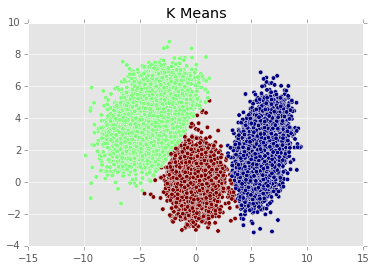

In [168]:
import sklearn.cluster
dfdata=pd.DataFrame(data,columns=["X","Y"])
KMeans = sklearn.cluster.KMeans(n_clusters=3, init='random', n_init=10, max_iter=500, tol=0.0001)
KMeans.fit(dfdata)
plt.scatter(dfdata.X, dfdata.Y,c=KMeans.labels_);
plt.title("K Means");


In [165]:
t = time.time()
KMeans.fit(dfdata)
elapsed_time = time.time() - t
elapsed_time

0.23090386390686035

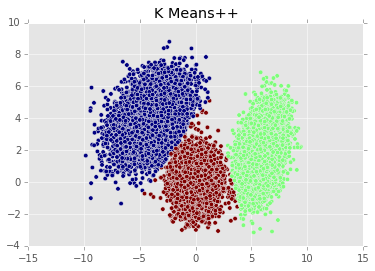

In [166]:
KMeansPP = sklearn.cluster.KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=500, tol=0.0001)
KMeansPP.fit(dfdata)
plt.scatter(dfdata.X, dfdata.Y,c=KMeansPP.labels_);
plt.title("K Means++");

In [167]:
t = time.time()
KMeansPP.fit(dfdata)
elapsed_time = time.time() - t
elapsed_time

0.10847687721252441

## Unit Code Tests

In [1]:
%%file costfunction.py

import numpy as np

def Cost(c, data):
    return np.sum([min(np.sum((c-pts)**2,axis=1)) for pts in data]) 

Overwriting costfunction.py


In [2]:
%%file test_costfunction.py

import numpy as np
from numpy.testing import assert_almost_equal
from costfunction import Cost

def test_non_negativity():
    for i in range(10):
        data = np.random.normal(size=(20,2))
        c = data[np.random.choice(range(20),1),]
        assert Cost(c, data) >= 0

def test_coincidence_when_zero():
    data = np.random.normal(size=(20,2))
    c = data
    assert Cost(c, data) == 0

def test_coincidence_when_not_zero():
     for i in range(10):
        data = np.random.normal(size=(20,2))
        c = data[np.random.choice(range(20),19),]
        assert Cost(c, data) != 0


Overwriting test_costfunction.py


In [3]:
%%file probability.py


from costfunction import Cost
import numpy as np

def Prob(c,data,l):
    cost = Cost(c,data)
    return np.array([(min(np.sum((c-pts)**2,axis=1))) * l / cost for pts in data])  


Overwriting probability.py


In [37]:
%%file test_probability.py

import numpy as np
from numpy.testing import assert_almost_equal
from costfunction import Cost
from probability import Prob

def test_non_negativity():
    for i in range(10):
        data = np.random.normal(size=(20,2))
        c = data[np.random.choice(range(20),1),]
        assert np.alltrue(Prob(c, data, 1) >= 0)

def test_sum():
    for i in range(10):
        data = np.random.normal(size=(20,2))
        c = data[np.random.choice(range(20),1),]
        assert_almost_equal(np.sum(Prob(c, data, 1)),1)
        

Overwriting test_probability.py


In [63]:
%%file mainfunc.py

import os
import sys
import glob
import random
import sklearn
import sklearn.cluster
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import division
%matplotlib inline
plt.style.use('ggplot')
from costfunction import Cost
from probability import Prob


def KMeansNaive(data, k, l):
    N = len(data)
    # 1. Random sample a point
    C = np.array(data[np.random.choice(range(N),1),])
    # 2. Compute phi = cost
    phi = Cost(C, data)
    # 3-6. For loop
    for i in range(np.ceil(np.log(phi)).astype(int)):
        cPrime = data[Prob(C, data, l) > np.random.uniform(size = N),]
        C = np.concatenate((C, cPrime))    
    # 7. Compute weight
    closest = [np.argmin(np.sum((C-pts)**2,axis=1)) for pts in data];
    wx = [closest.count(i) for i in range(len(C))]
    weight = wx/np.sum(wx)    
    # 8. Recluster
    newC = data[np.random.choice(range(len(C)),size=1,p=weight),]
    newdata = C
    for i in range(k-1):
        Probability = Prob(newC, newdata, l) * weight
        newcPrime = data[np.random.choice(range(len(C)), size=1, p=Probability/np.sum(Probability)),]
        newC = np.concatenate((newC,newcPrime))
    # Finish k-means|| initialization    
    # K-means with initial point chosen by k-means|| algorithm
    KMeansPP = sklearn.cluster.KMeans(n_clusters=k, n_init=1, init=newC, max_iter=500, tol=0.0001)
    KMeansPP.fit(data);
    return KMeansPP

Overwriting mainfunc.py


In [70]:
%%file test_mainfunc.py


import numpy as np
from numpy.testing import assert_almost_equal
from costfunction import Cost
from probability import Prob
from mainfunc import KMeansNaive

def test_klevels():
    for i in range(10):
        data = np.random.normal(size=(20,2))
        k = 3
        assert len(set(KMeansParallel(data = data, k = k, l = 2*k).labels_)) == k

def test_len_labels():
    for i in range(10):
        data = np.random.normal(size=(20,2))
        k = 3
        assert len(KMeansParallel(data = data, k = k, l = 2*k).labels_) == len(data)

Overwriting test_mainfunc.py


In [71]:
! py.test

============================= test session starts ==============================
platform darwin -- Python 2.7.9 -- py-1.4.26 -- pytest-2.6.4
collected 15 items / 5 errors 

test_costfunction.py ...
test_probability.py ..
tests/test_CostFunction.py ...
tests/test_KMeansParallel.py ....
tests/test_SamplingProbability.py ...

==================================== ERRORS ====================================
________________________ ERROR collecting test_main.py _________________________
../Documents/anaconda/lib/python2.7/site-packages/_pytest/python.py:463: in _importtestmodule
    mod = self.fspath.pyimport(ensuresyspath=True)
../Documents/anaconda/lib/python2.7/site-packages/py/_path/local.py:641: in pyimport
    __import__(modname)
../Documents/anaconda/lib/python2.7/site-packages/_pytest/assertion/rewrite.py:159: in load_module
    py.builtin.exec_(co, mod.__dict__)
test_main.py:6: in <module>
    from main import KMeansNaive
E     File "/Users/lichris/Desktop/main.py", line 10
E     